In [9]:
import tweepy
import sys
import pandas as pd
import datetime
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
analyser = SentimentIntensityAnalyzer()
consumer_key = "3PoIIQ89J76xSdB4Fx29gptSo"
consumer_secret = "PaFNV5IBZO5eW51Cc8c1I5th7ZG3TUeJ7tb7ommRZ7bf8AnQw8"
access_token = "1186703010350686208-nvy4G6SLnqp0vOCwaCoxZX1TD55s1K"
access_token_secret = "AIvDWxupzjZvzPuvcMmnUJe7q0e0vkG8EDmC6ZaLqTVv9"

In [3]:
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True) 

In [4]:
# The Twitter user who we want to get tweets from
name = "Nigel_Farage"

In [5]:
# Number of tweets to pull
tweetCount = 20

# Calling the user_timeline function with our parameters
results = api.user_timeline(id=name, count=tweetCount, tweet_mode = 'extended')

# printing the text stored inside the tweet object
tweets = [[tweet.full_text] for tweet in results]

print(tweets[0])
timestamp_list = [tweet.created_at for tweet in results]
print(timestamp_list[:3])

['I’m in Workington this morning to announce our general election candidate. \n\nThe London media obsession with ‘Workington Man’ is patronising cobblers! https://t.co/DyNENSVndT']
[datetime.datetime(2019, 11, 6, 11, 40, 49), datetime.datetime(2019, 11, 6, 10, 55, 14), datetime.datetime(2019, 11, 6, 10, 1, 12)]


In [7]:
def limit_handled(cursor):
    while True:
        try:
            yield cursor.next()
        except tweepy.RateLimitError:
            time.sleep(15 * 60)

In [26]:
file_name = 'brexit-data'

try:
    df = pd.read_csv("{}.csv".format(file_name))
    i = df.shape[0]
    id = df.tail(1)['id']
    print(id)
    
except:
    df = pd.DataFrame(columns = ['id','user_name', 'tweet_text', 'reply_list', 
                             'user_followers', 'user_location', 'user_verified',
                             'like_count', 'rt_count', 'timestamp'])
    i = 0
    id=0
tweets = []


non_bmp_map = dict.fromkeys(range(0x10000, sys.maxunicode + 1), 0xfffd)  

for page in tweepy.Cursor(api.search, q='brexit', lang="en", tweet_mode='extended', timeout=999999,count = 100,since_id = id).pages(): 
    for index,tweet in enumerate(page):
        if (datetime.datetime.now() - tweet.created_at).days < 30:
            print(i, end='\r')
            df.loc[i,'id'] = tweet.id
            df.loc[i, 'tweet_text'] = tweet.full_text
            df.loc[i, 'user_name'] = tweet.user.name
            df.loc[i, 'reply_list'] = None
            df.loc[i, 'user_followers'] = tweet.user.followers_count
            df.loc[i, 'user_location'] = tweet.user.location
            df.loc[i, 'user_verified'] = tweet.user.verified
            df.loc[i, 'like_count'] = tweet.favorite_count
            df.loc[i, 'rt_count'] = tweet.retweet_count
            df.loc[i, 'timestamp'] = tweet.created_at
            i+=1
    df.to_csv('{}.csv'.format(file_name))


99    1192102558036348928
Name: id, dtype: int64


KeyboardInterrupt: 

In [25]:
df.head()

,user_name,tweet_text,reply_list,user_followers,user_location,user_verified,like_count,rt_count,timestamp
0,margaret hennessy,RT @KTHopkins: I will have a BREXIT UPDATE for...,None,169,,False,0,123,2019-10-23 11:54:35
1,Hen Wraig Ddig #FBPE,RT @BrechinYes2: Ian Blackford asks Johnston w...,None,583,"United Kingdom, Wales",False,0,36,2019-10-23 11:54:35
2,Dougie Graham,RT @Nigel_Farage: Boris Johnson says that the ...,None,425,,False,0,904,2019-10-23 11:54:35
3,Gertie Pye,RT @Shining09807978: Right here !!! \n\nAnna S...,None,186,,False,0,282,2019-10-23 11:54:35
4,James Lawler,"RT @Doozy_45: Hillary Benn:\n""When we get to t...",None,3057,United Kingdom,False,0,217,2019-10-23 11:54:35


## 

In [123]:
def populate_row(df,i,tweet,tweet_orig_author):
    tweet_text = tweet.full_text.replace("@{}".format(tweet_orig_author),"")
    score = analyser.polarity_scores(tweet_text)
    df.loc[i, 'tweet_text'] = tweet_text
    df.loc[i, 'user_name'] = tweet.user.name
    df.loc[i, 'user_followers'] = tweet.user.followers_count
    df.loc[i, 'user_location'] = tweet.user.location
    df.loc[i, 'user_verified'] = tweet.user.verified
    df.loc[i, 'like_count'] = tweet.favorite_count
    df.loc[i, 'rt_count'] = tweet.retweet_count
    df.loc[i, 'timestamp'] = tweet.created_at
    df.loc[i, 'positive_score'] = score['pos']
    df.loc[i, 'negative_score'] = score['neg']
    df.loc[i, 'neutral_score'] = score['neu']
    df.loc[i,'compound_score'] = score['compound']

In [133]:
def get_tweet_responses(tweet_orig):
    df = pd.DataFrame(columns = ['user_name', 'tweet_text', 
                             'user_followers', 'user_location', 'user_verified',
                             'like_count', 'rt_count', 'timestamp'])
    i=0
    populate_row(df,i,tweet_orig,tweet_orig.user.screen_name)
    for tweet in tweepy.Cursor(api.search, q='to:{}'.format(tweet_orig.user.screen_name), tweet_mode='extended', result_type='recent',timeout=999999).items(1000):
            if hasattr(tweet, 'in_reply_to_status_id_str'):
                if (tweet.in_reply_to_status_id_str==tweet_orig.id_str):
                    i+=1
                    populate_row(df,i,tweet,tweet_orig.user.screen_name)
                    print(i, end='\r')
    df.to_csv('{}_responses.csv'.format(tweet_orig.id_str))
                    

In [134]:
def get_user_timeline(username,limit):
    for full_tweet in tweepy.Cursor(api.user_timeline, screen_name=username, lang="en", tweet_mode='extended', timeout=999999).items(limit):
        get_tweet_responses(full_tweet)

In [135]:
get_user_timeline("Nigel_Farage",1)

In [138]:
responses_df = pd.read_csv("1187647526285008896_responses.csv")

In [145]:
def plot_tweet_sentiment(data):
    labels = ["Positive", "Negative", "Neutral"]
    colors = ["yellowgreen", "lightcoral", "lightskyblue"]
    negative = data["negative_score"][1:].sum()
    positive = data["positive_score"][1:].sum()
    neutral = data["neutral_score"][1:].sum()
    sentiments = [positive,negative,neutral]
    plt.pie(sentiments, colors=colors,labels=labels,autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.tight_layout()
    plt.title("Sentimental Analysis of tweet by {}\n{}".format(data["user_name"][0],data["tweet_text"][0]))
    plt.show()
    
    

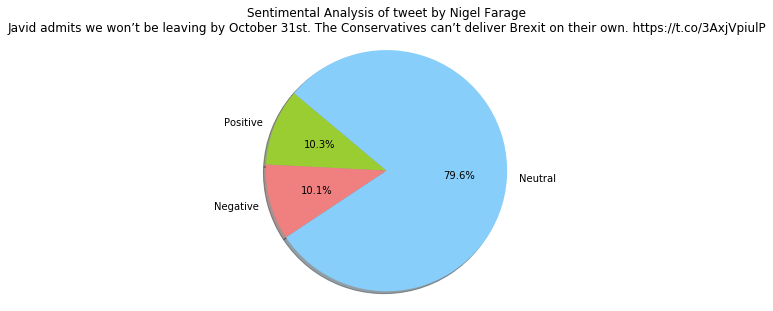

In [146]:
plot_tweet_sentiment(responses_df)